## INP concentrations
Trying to plot INP concentration against isotherm to compare with measurements in Tobo et al. 2019

In [10]:
from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average
    )

%matplotlib inline

In [11]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_cloudtop/'
output_dir = 'figures/'
model_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

Running on storm.uio.no, attempting to mount ns9600k/jonahks/ from NIRD
Can access all directory paths: False


Get observational data

In [12]:
os.getcwd()

'/home/jonahks/drivemount'

In [13]:
os.chdir('/home/jonahks/Downloads/')

In [15]:
inpobs = pd.read_csv('inp_obs.csv', names=['T','INP'])[:29] # 

In [34]:
def upper_fit(t):
    INP_25C = 0.14
    slope = 0.703
    inp_t = INP_25C*(slope**(t + 24.83))
    return inp_t

def lower_fit(t):
    INP_25C = 0.027
    slope = 0.5537979124908083
    inp_t = INP_25C*(slope**(t + 24.87))
    return inp_t

def mid_fit(t):
    INP_25C = 0.05
    slope = 0.7
    inp_t = INP_25C*(slope**(t + 24.87))
    return inp_t

In [38]:
inpobs['upper'] = inpobs['INP'] > mid_fit(inpobs['T'])

(0.0001, 1)

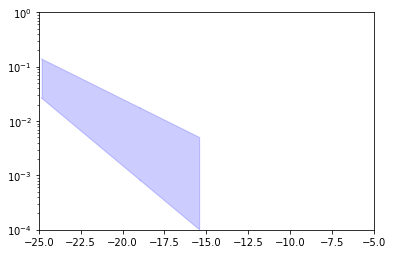

In [52]:
plt.fill_between(inpobs['T'], y1=lower_fit(inpobs['T']), y2=upper_fit(inpobs['T']),alpha=0.2, color='blue')
plt.yscale('log')
plt.xlim((-25,-5)); plt.ylim((1e-4,1))

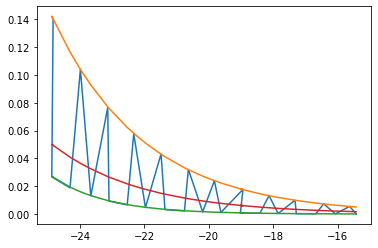

In [35]:
plt.plot(inpobs['T'], inpobs['INP'])
plt.plot(inpobs['T'], upper_fit(inpobs['T']))
plt.plot(inpobs['T'], lower_fit(inpobs['T']))
plt.plot(inpobs['T'], mid_fit(inpobs['T']))

In [45]:
inpobs.loc[inpobs['upper'] == True]

0    -24.835750
3    -23.987694
5    -23.139639
8    -22.331967
10   -21.483911
13   -20.635856
15   -19.828184
17   -18.939744
20   -18.132072
22   -17.324400
25   -16.435961
27   -15.628289
Name: T, dtype: float64

In [44]:
inpobs.loc[inpobs['upper'] == False]

,T,INP,upper,lower
1,-24.876134,0.026748,False,True
2,-24.310763,0.018891,False,True
4,-23.664626,0.013108,False,True
6,-23.099255,0.009323,False,True
7,-22.533885,0.006585,False,True
9,-21.968514,0.004634,False,True
11,-21.362760,0.003239,False,True
12,-20.757006,0.002279,False,True
14,-20.191636,0.001615,False,True
16,-19.626266,0.001139,False,True


In [25]:
(1.02e-4 / 0.027)**(1/(24.87-15.43))

0.5537979124908083

Determine the correct file paths and load the netcdf files

In [3]:
filepath = ''

Add INP sum variable, then mask non-Arctic latitudes and weight by cell area to produce concentration vs. temperature relation.

In [88]:
# Load NorESM data
ds = xr.open_dataset('%s/%s.nc' % (run_dir,case))
if (len(ds['time']) > 1):
    ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
ds = add_weights(ds)

ds['INP_sum'] = ds['NIMIX_HET'] + ds['NIMIX_IMM'] + ds['NIMIX_CNT'] # add new variable

ds['INP_sum_TAVG'] = ds['INP_sum'].mean(dim = 'time', skipna=True)

# Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
mask1= np.bitwise_or(ds['lat']<_rng[0], ds['lat']>_rng[1])

weight = ds['cell_weight']

inp = 100*masked_average(ds['INP_sum_TAVG'], dim=['lat','lon'],weights=weight, mask=mask)
tt = 100*masked_average(ds['INP_sum_TAVG'], dim=['lat','lon'],weights=weight, mask=mask)

stdev1 = 100*np.std(ct_slf_caliop['SLF'].sel(lat=slice(_rng[0],_rng[1])), axis=(0,1))


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Plot Stuff

Text(0.5,0.98,'20191230_130025_singleparam_cttest15_wbf_1_inp_1')

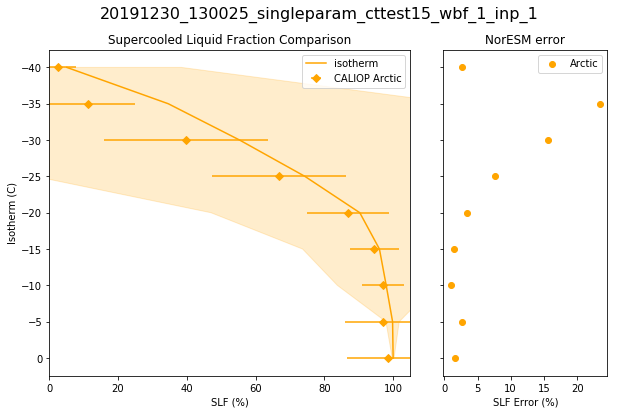

In [96]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)

fig1.gca().invert_yaxis()

colors = ['blue', 'orange', 'red']

for b,c in zip(bands, colors):
    if b == 'Arctic':
        f1_ax1.errorbar(df['CALIOP %s SLF' % b], df['isotherm'], xerr=2*df['CALIOP %s StDev' % b], label='CALIOP %s' % b, color = c, fmt='o', marker='D')
        f1_ax1.plot(df['NorESM %s SLF' % b], df['isotherm'], color = c) #, label=b)
        f1_ax1.fill_betweenx(df['isotherm'], df['NorESM %s SLF' % b] - 2*df['NorESM %s StDev' % b], df['NorESM %s SLF' % b] + 2*df['NorESM %s StDev' % b], alpha=0.2, color=c)

        slf_error = df['NorESM %s SLF' % b] - df['CALIOP %s SLF' % b]
        f1_ax2.scatter(slf_error, df['isotherm'], color=c, label=b)

#_r = regress_1d(isos, all_slf_clean[error])
#_s = _r.score(isos, all_slf_clean[error])
#f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

f1_ax1.set_xlim((0,105))
f1_ax1.legend()
f1_ax2.legend()

fig1.suptitle(case, fontsize=16)